In [1]:
import gym
import torch
import torch.nn as nn
import torch.optim as opt
from torch import Tensor
from torch.autograd import Variable
from collections import namedtuple
from itertools import count
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt
from os.path import join as joindir
from os import makedirs as mkdir
import pandas as pd
import numpy as np
import argparse
import datetime
import math

In [2]:
from gym import spaces, logger
from gym.utils import seeding

In [3]:
class FreshProduceEnv(gym.Env):
    """
    Description:
        
    Source:
        
    Observation:
        Type: Box(2)
        Num     Observation               Min                     Max
        0       Inventory level            0                      500
        1       food quality               0                       1

    Actions:
        Type: Box(2)
        Num     Action                    Min                     Max
        0       price                      0                       6
        1       information disclosure     0                       1
        Note: 
    Reward:
        profit
    Starting State:
        initial observations are [500, 1]
    Episode Termination:
        Episode length is greater than 12.
        Inventory level is less than 0.
        food quality is less than 0.
    """
    def __init__(self, customer1_rato, customer2_rato, customer3_rato):
        '''
        customer1_rato, customer2_rato, customer3_rato 分别为3种顾客的的市场占比
        '''
        # 环境参数
        # 回合数目
        self.T = 12
        # 商品单位库存成本
        self.q = 3
        # 商品真实的恶化率
        self.gamma = 0.1
        # 3种顾客内心的恶化率的分布参数（服从正态分布）
        self.mu_01 = 0.15
        self.mu_02 = self.gamma
        self.mu_03 = 0.05
        self.var_0 = 0.001
        # 质量噪声分布的参数 N(0, sigma^2)
        self.var = 0.004
        # 保留价格F()和保留质量M()的参数
        self.roh_F = 4
        self.k_F = 0.004
        self.roh_M = 4
        self.k_M = 1
        # 每个时期的顾客到达率
        self.lambda_ = 70
        # 折扣率
        self.alpha = 0.9
        # 3种顾客所占的比例
        self.customer1_rato = customer1_rato
        self.customer2_rato = customer2_rato
        self.customer3_rato = customer3_rato
        # 信念更新的步长
        self.alpha_step = 1e-4
        # 商品质量参数
        self.Q = 1
        # 库存参数
        self.C = 500
        
        # observation [库存水平，质量] 的维度以及上下界
        obs_low = np.array([0, 0], dtype=np.float32)
        obs_high = np.array([self.C, self.Q], dtype=np.float32)
        self.observation_space = spaces.Box(low=obs_low, high=obs_high, dtype=np.float32)
        
        # action [p_t, m_t]
        act_low = np.array([0, 0], dtype=np.float32)
        act_high = np.array([6, 1], dtype=np.float32)
        self.action_space = spaces.Box(low=act_low, high=act_high, dtype=np.float32)
        
        self.seed()
        self.state = None
        self.steps_beyond_done = None
        
    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]
    
    def _updateBelief(self, gamma_0, mu_0):
        # 更新恶化率 
        # 依据论文公式
        while True:
            # 负梯度
            temp = np.multiply(np.multiply((np.array(self.disclosure_theta) - np.exp(-gamma_0 * np.array(self.disclosure_time))),
                               np.array(self.disclosure_time)), np.exp(-gamma_0 * np.array(self.disclosure_time))).sum() + \
                   (self.var / self.var_0) * (gamma_0 - mu_0)
            # 最大化后验，所以这里是正梯度
            gamma_1 = gamma_0 - self.alpha_step * temp
            delta = abs(gamma_1-gamma_0)
            gamma_0 = gamma_1
            if delta < 1e-6:
                break
        return gamma_0
    
    @staticmethod
    def weibCdf(x, shape, scale):
        '''
        weibull分布函数
        shape参数，scale参数
        '''
        if x < 0:
            return 0
        else:
            return 1 - np.exp(-np.power(x / scale, shape))
    
    
    def _cacluateBuyNum(self, gamma, time, p_t, arrived_customer):
        # 依据价格和质量计算购买人数
        # 质量噪声
        epsilon = np.random.normal(loc=0, scale=np.sqrt(self.var), size=1)[0]
        # 顾客的感知质量
        customer_theta = max(np.exp(-gamma * time) + epsilon, 1e-10)
        # 购买概率 (1 - F(p_t))M(theta)
        buy_prob = ((1 - self.weibCdf(p_t, self.k_F, self.roh_F))*self.weibCdf(customer_theta, self.k_M, self.roh_M))
        buy_nums = 0
        for _ in range(arrived_customer):
            if np.random.uniform() < buy_prob:
                buy_nums += 1
                
        return buy_nums
        
    def step(self, action):
        '''
        action 零售商设定价格和披露信息的概率
        顾客依据披露的信息和设定的价格，更新自己的先验信息，发生购买行为，
        '''
       
        p_t, m_t = action[0], action[1]
        
        if np.random.uniform() <= m_t:
            self.disclosure_theta.append(self.Q)
            self.disclosure_time.append(self.time)
            self.gamma_1 = self._updateBelief(self.gamma_1, self.mu_01)
            self.gamma_2 = self._updateBelief(self.gamma_2, self.mu_02)
            self.gamma_3 = self._updateBelief(self.gamma_3, self.mu_03)
        # 顾客到达服从泊松分布
        nums_customer = np.random.poisson(lam=self.lambda_, size=1)[0]
        nums_customer1 = 0
        nums_customer2 = 0
        nums_customer3 = 0
        for _ in range(nums_customer):
            if np.random.uniform() < self.customer1_rato:
                nums_customer1 += 1
            elif np.random.uniform() < self.customer1_rato + self.customer2_rato:
                nums_customer2 += 1
            else:
                nums_customer3 += 1
            
        # 计算购买的人数，价格低于保留价格，质量高于保留质量
        self.buy_nums = 0
        for gamma, customer_num in zip([self.gamma_1, self.gamma_2, self.gamma_3],
                         [nums_customer1, nums_customer2, nums_customer3]):
            self.buy_nums += self._cacluateBuyNum(gamma, self.time, p_t, customer_num)
            
        # 计算奖励 == 利润
        profit = min(self.C, self.buy_nums) * (p_t - self.q)
        # 库存变化
        self.C = max(self.C - self.buy_nums, 0)
        # 质量变化的噪声
        epsilon_t = np.random.normal(loc=0, scale=np.sqrt(self.var), size=1)[0]
        # 质量变化
        self.Q = max(np.exp(-self.gamma * self.time) + epsilon_t, 0.0)
        # 更新状态
        self.state = [self.C, self.Q]
        # 是否结束
        done = bool(self.C==0 or self.time>=self.T or self.Q==0.0)
        
        if not done:
            reward = profit
        elif self.steps_beyond_done is None:
            # 回合结束
            self.steps_beyond_done = 0
            reward = profit
        else:
            # 如果回合结束了依旧调用的话抛出警告
            if self.steps_beyond_done == 0:
                logger.warn(
                    "You are calling 'step()' even though this "
                    "environment has already returned done = True. You "
                    "should always call 'reset()' once you receive 'done = "
                    "True' -- any further steps are undefined behavior."
                )
            self.steps_beyond_done += 1

        self.time +=1
        
        return np.array(self.state), reward, done, {}
        
    
    def reset(self):
        # 顾客初始的信念
        self.gamma_1 = np.random.normal(loc=self.mu_01, scale=np.sqrt(self.var_0), size=1)[0]
        self.gamma_2 = np.random.normal(loc=self.mu_02, scale=np.sqrt(self.var_0), size=1)[0]
        self.gamma_3 = np.random.normal(loc=self.mu_03, scale=np.sqrt(self.var_0), size=1)[0]
        # 商品质量初始化
        self.Q = 1
        # 库存状态初始化
        self.C = 500
        
        # 零售商披露的质量、时间
        self.disclosure_theta = []
        self.disclosure_time = []
        
        # 当前阶段
        self.time = 1
        
        # 状态初始化
        self.state = [self.C, self.Q]
        
        self.steps_beyond_done = None
        
        return np.array(self.state)

In [6]:
Transition = namedtuple('Transition', ('state', 'value', 'action', 'logproba', 'mask', 'next_state', 'reward'))
EPS = 1e-10

In [30]:
class args(object):
    env_name = 'Hopper-v2'
    seed = 1234
    num_episode = 500 
    batch_size = 64 
    max_step_per_round = 12
    gamma = 0.995
    lamda = 0.97
    log_num_episode = 1
    num_epoch = 3 # 经验池样本的复用次数
    minibatch_size = 16
    clip = 0.2
    loss_coeff_value = 0.5
    loss_coeff_entropy = 0.01
    lr = 3e-4
    num_parallel_run = 5
    # tricks
    schedule_adam = 'linear'
    schedule_clip = 'linear'
    layer_norm = True
    state_norm = True
    advantage_norm = True
    lossvalue_norm = True


class RunningStat(object):
    def __init__(self, shape):
        self._n = 0
        self._M = np.zeros(shape)
        self._S = np.zeros(shape)

    def push(self, x):
        x = np.asarray(x)
        assert x.shape == self._M.shape
        self._n += 1
        if self._n == 1:
            self._M[...] = x
        else:
            oldM = self._M.copy()
            self._M[...] = oldM + (x - oldM) / self._n
            self._S[...] = self._S + (x - oldM) * (x - self._M)

    @property
    def n(self):
        return self._n

    @property
    def mean(self):
        return self._M

    @property
    def var(self):
        return self._S / (self._n - 1) if self._n > 1 else np.square(self._M)

    @property
    def std(self):
        return np.sqrt(self.var)

    @property
    def shape(self):
        return self._M.shape


class ZFilter:
    """
    y = (x-mean)/std
    using running estimates of mean,std
    """

    def __init__(self, shape, demean=True, destd=True, clip=10.0):
        self.demean = demean
        self.destd = destd
        self.clip = clip

        self.rs = RunningStat(shape)

    def __call__(self, x, update=True):
        if update: self.rs.push(x)
        if self.demean:
            x = x - self.rs.mean
        if self.destd:
            x = x / (self.rs.std + 1e-8)
        if self.clip:
            x = np.clip(x, -self.clip, self.clip)
        return x

    def output_shape(self, input_space):
        return input_space.shape


class ActorCritic(nn.Module):
    def __init__(self, num_inputs, num_outputs, layer_norm=True):
        super(ActorCritic, self).__init__()
        
        self.actor_fc1 = nn.Linear(num_inputs, 64)
        self.actor_fc2 = nn.Linear(64, 32)
        self.actor_fc3 = nn.Linear(32, num_outputs)
        self.actor_logstd = nn.Parameter(torch.zeros(1, num_outputs))

        self.critic_fc1 = nn.Linear(num_inputs, 64)
        self.critic_fc2 = nn.Linear(64, 32)
        self.critic_fc3 = nn.Linear(32, 1)

        if layer_norm:
            self.layer_norm(self.actor_fc1, std=1.0)
            self.layer_norm(self.actor_fc2, std=1.0)
            self.layer_norm(self.actor_fc3, std=0.01)

            self.layer_norm(self.critic_fc1, std=1.0)
            self.layer_norm(self.critic_fc2, std=1.0)
            self.layer_norm(self.critic_fc3, std=1.0)

    @staticmethod
    def layer_norm(layer, std=1.0, bias_const=0.0):
        torch.nn.init.orthogonal_(layer.weight, std)
        torch.nn.init.constant_(layer.bias, bias_const)

    def forward(self, states):
        """
        run policy network (actor) as well as value network (critic)
        :param states: a Tensor2 represents states
        :return: 3 Tensor2
        """
        action_mean, action_logstd = self._forward_actor(states)
        critic_value = self._forward_critic(states)
        return action_mean, action_logstd, critic_value

    def _forward_actor(self, states):
        x = torch.tanh(self.actor_fc1(states))
        x = torch.tanh(self.actor_fc2(x))
        action_mean = self.actor_fc3(x)
        action_logstd = self.actor_logstd.expand_as(action_mean)
        return action_mean, action_logstd

    def _forward_critic(self, states):
        x = torch.tanh(self.critic_fc1(states))
        x = torch.tanh(self.critic_fc2(x))
        critic_value = self.critic_fc3(x)
        return critic_value

    def select_action(self, action_mean, action_logstd, return_logproba=True):
        """
        given mean and std, sample an action from normal(mean, std)
        also returns probability of the given chosen
        """
        action_std = torch.exp(action_logstd)
        action = torch.normal(action_mean, action_std)
        if return_logproba:
            logproba = self._normal_logproba(action, action_mean, action_logstd, action_std)
        return action, logproba

    @staticmethod
    def _normal_logproba(x, mean, logstd, std=None):
        if std is None:
            std = torch.exp(logstd)

        std_sq = std.pow(2)
        logproba = - 0.5 * math.log(2 * math.pi) - logstd - (x - mean).pow(2) / (2 * std_sq)
        return logproba.sum(1)

    def get_logproba(self, states, actions):
        """
        return probability of chosen the given actions under corresponding states of current network
        :param states: Tensor
        :param actions: Tensor
        """
        action_mean, action_logstd = self._forward_actor(states)
        logproba = self._normal_logproba(actions, action_mean, action_logstd)
        return logproba

    
class Memory(object):
    def __init__(self):
        self.memory = []

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self):
        return Transition(*zip(*self.memory))

    def __len__(self):
        return len(self.memory)

def ppo(args, env):
    
    num_inputs = env.observation_space.shape[0]
    num_actions = env.action_space.shape[0]

    env.seed(args.seed)
    torch.manual_seed(args.seed)

    network = ActorCritic(num_inputs, num_actions, layer_norm=args.layer_norm)
    optimizer = opt.Adam(network.parameters(), lr=args.lr)

    running_state = ZFilter((num_inputs,), clip=5.0)
    
    # record average 1-round cumulative reward in every episode
    reward_record = []
    global_steps = 0

    lr_now = args.lr
    clip_now = args.clip

    for i_episode in range(args.num_episode):
        # step1: perform current policy to collect trajectories
        # this is an on-policy method!
        memory = Memory()
        num_steps = 0
        reward_list = []
        len_list = []
        while num_steps < args.batch_size:
            state = env.reset()
            if args.state_norm:
                state = running_state(state)
            reward_sum = 0
            for t in range(args.max_step_per_round):
                action_mean, action_logstd, value = network(Tensor(state).unsqueeze(0))
                action, logproba = network.select_action(action_mean, action_logstd)
                action = action.data.numpy()[0]
                logproba = logproba.data.numpy()[0]
                next_state, reward, done, _ = env.step(action)
                reward_sum += reward
                if args.state_norm:
                    next_state = running_state(next_state)
                mask = 0 if done else 1

                memory.push(state, value, action, logproba, mask, next_state, reward)
                
                if done:
                    break
                    
                state = next_state
                
            num_steps += (t + 1)
            global_steps += (t + 1)
            reward_list.append(reward_sum)
            len_list.append(t + 1)
        reward_record.append({
            'episode': i_episode, 
            'steps': global_steps, 
            'meanepreward': np.mean(reward_list), 
            'meaneplen': np.mean(len_list)})

        batch = memory.sample()
        batch_size = len(memory)
        
        # step2: extract variables from trajectories
        rewards = Tensor(batch.reward)
        values = Tensor(batch.value)
        masks = Tensor(batch.mask)
        actions = Tensor(batch.action)
        states = Tensor(batch.state)
        oldlogproba = Tensor(batch.logproba)
        
        returns = Tensor(batch_size)
        deltas = Tensor(batch_size)
        advantages = Tensor(batch_size)

        prev_return = 0
        prev_value = 0
        prev_advantage = 0
        for i in reversed(range(batch_size)):
            returns[i] = rewards[i] + args.gamma * prev_return * masks[i]
            deltas[i] = rewards[i] + args.gamma * prev_value * masks[i] - values[i]
            # ref: https://arxiv.org/pdf/1506.02438.pdf (generalization advantage estimate)
            advantages[i] = deltas[i] + args.gamma * args.lamda * prev_advantage * masks[i]

            prev_return = returns[i]
            prev_value = values[i]
            prev_advantage = advantages[i]
        if args.advantage_norm:
            advantages = (advantages - advantages.mean()) / (advantages.std() + EPS)

        for i_epoch in range(int(args.num_epoch * batch_size / args.minibatch_size)):
            # sample from current batch
            minibatch_ind = np.random.choice(batch_size, args.minibatch_size, replace=False)
            minibatch_states = states[minibatch_ind]
            minibatch_actions = actions[minibatch_ind]
            minibatch_oldlogproba = oldlogproba[minibatch_ind]
            minibatch_newlogproba = network.get_logproba(minibatch_states, minibatch_actions)
            minibatch_advantages = advantages[minibatch_ind]
            minibatch_returns = returns[minibatch_ind]
            minibatch_newvalues = network._forward_critic(minibatch_states).flatten()

            ratio =  torch.exp(minibatch_newlogproba - minibatch_oldlogproba)
            surr1 = ratio * minibatch_advantages
            surr2 = ratio.clamp(1 - clip_now, 1 + clip_now) * minibatch_advantages
            loss_surr = - torch.mean(torch.min(surr1, surr2))

            # not sure the value loss should be clipped as well 
            # clip example: https://github.com/Jiankai-Sun/Proximal-Policy-Optimization-in-Pytorch/blob/master/ppo.py
            # however, it does not make sense to clip score-like value by a dimensionless clipping parameter
            # moreover, original paper does not mention clipped value 
            if args.lossvalue_norm:
                minibatch_return_6std = 6 * minibatch_returns.std()
                loss_value = torch.mean((minibatch_newvalues - minibatch_returns).pow(2)) / minibatch_return_6std
            else:
                loss_value = torch.mean((minibatch_newvalues - minibatch_returns).pow(2))

            loss_entropy = torch.mean(torch.exp(minibatch_newlogproba) * minibatch_newlogproba)

            total_loss = loss_surr + args.loss_coeff_value * loss_value + args.loss_coeff_entropy * loss_entropy
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

        if args.schedule_clip == 'linear':
            ep_ratio = 1 - (i_episode / args.num_episode)
            clip_now = args.clip * ep_ratio

        if args.schedule_adam == 'linear':
            ep_ratio = 1 - (i_episode / args.num_episode)
            lr_now = args.lr * ep_ratio
            # set learning rate
            # ref: https://stackoverflow.com/questions/48324152/
            for g in optimizer.param_groups:
                g['lr'] = lr_now

        if i_episode % args.log_num_episode == 0:
            print('Finished episode: {} Reward: {:.4f} total_loss = {:.4f} = {:.4f} + {} * {:.4f} + {} * {:.4f}' \
                .format(i_episode, reward_record[-1]['meanepreward'], total_loss.data, loss_surr.data, args.loss_coeff_value, 
                loss_value.data, args.loss_coeff_entropy, loss_entropy.data))
            print('-----------------')

    return reward_record

def test(args, env):
    record_dfs = []
    for i in range(args.num_parallel_run):
        args.seed += 1
        reward_record = pd.DataFrame(ppo(args, env))
        reward_record['#parallel_run'] = i
        record_dfs.append(reward_record)
    record_dfs = pd.concat(record_dfs, axis=0)
    record_dfs.to_csv('ppo.csv')
    
if __name__ == '__main__':
    args.env_name = env_name
    env = FreshProduceEnv(1/3, 1/3, 1/3)
    test(args, env)

Finished episode: 0 Reward: -258.7708 total_loss = 26.6978 = 0.2853 + 0.5 * 52.8295 + 0.01 * -0.2254
-----------------
Finished episode: 1 Reward: -292.2503 total_loss = 19.2184 = -0.1876 + 0.5 * 38.8163 + 0.01 * -0.2117
-----------------
Finished episode: 2 Reward: -228.2813 total_loss = 21.2621 = 0.2387 + 0.5 * 42.0510 + 0.01 * -0.2028
-----------------
Finished episode: 3 Reward: -263.9067 total_loss = 26.4140 = 0.3202 + 0.5 * 52.1914 + 0.01 * -0.1913
-----------------
Finished episode: 4 Reward: -241.8265 total_loss = 23.4028 = 0.3140 + 0.5 * 46.1816 + 0.01 * -0.2019
-----------------
Finished episode: 5 Reward: -267.1302 total_loss = 19.2784 = -0.0250 + 0.5 * 38.6104 + 0.01 * -0.1832
-----------------
Finished episode: 6 Reward: -262.8788 total_loss = 25.7116 = 0.3262 + 0.5 * 50.7751 + 0.01 * -0.2132
-----------------
Finished episode: 7 Reward: -245.8314 total_loss = 19.6129 = 0.2943 + 0.5 * 38.6413 + 0.01 * -0.2038
-----------------
Finished episode: 8 Reward: -270.4960 total_lo

Finished episode: 70 Reward: 73.2622 total_loss = 5.2880 = 0.2989 + 0.5 * 9.9816 + 0.01 * -0.1764
-----------------
Finished episode: 71 Reward: 90.6246 total_loss = 8.7186 = -0.2370 + 0.5 * 17.9151 + 0.01 * -0.1976
-----------------
Finished episode: 72 Reward: 84.3855 total_loss = 5.1145 = 0.3504 + 0.5 * 9.5319 + 0.01 * -0.1861
-----------------
Finished episode: 73 Reward: 88.2386 total_loss = 8.2991 = 0.0836 + 0.5 * 16.4344 + 0.01 * -0.1632
-----------------
Finished episode: 74 Reward: 92.9725 total_loss = 13.7108 = -0.6912 + 0.5 * 28.8073 + 0.01 * -0.1624
-----------------
Finished episode: 75 Reward: 89.8649 total_loss = 6.7721 = 0.0523 + 0.5 * 13.4431 + 0.01 * -0.1787
-----------------
Finished episode: 76 Reward: 96.5359 total_loss = 4.4394 = 0.2411 + 0.5 * 8.4001 + 0.01 * -0.1694
-----------------
Finished episode: 77 Reward: 85.3158 total_loss = 5.2278 = -0.1282 + 0.5 * 10.7157 + 0.01 * -0.1813
-----------------
Finished episode: 78 Reward: 91.7745 total_loss = 6.4137 = -0.3

Finished episode: 139 Reward: 208.1894 total_loss = 12.4110 = -0.0020 + 0.5 * 24.8298 + 0.01 * -0.1891
-----------------
Finished episode: 140 Reward: 206.0283 total_loss = 14.6027 = -0.2509 + 0.5 * 29.7112 + 0.01 * -0.1945
-----------------
Finished episode: 141 Reward: 204.3800 total_loss = 14.2564 = -0.0541 + 0.5 * 28.6251 + 0.01 * -0.2044
-----------------
Finished episode: 142 Reward: 171.7983 total_loss = 12.5442 = -0.1682 + 0.5 * 25.4284 + 0.01 * -0.1730
-----------------
Finished episode: 143 Reward: 201.7649 total_loss = 23.0739 = -0.6402 + 0.5 * 47.4321 + 0.01 * -0.1905
-----------------
Finished episode: 144 Reward: 170.5646 total_loss = 11.0720 = -0.1797 + 0.5 * 22.5075 + 0.01 * -0.2043
-----------------
Finished episode: 145 Reward: 193.9537 total_loss = 13.5421 = -0.2987 + 0.5 * 27.6861 + 0.01 * -0.2144
-----------------
Finished episode: 146 Reward: 198.3269 total_loss = 10.2566 = 0.1631 + 0.5 * 20.1905 + 0.01 * -0.1797
-----------------
Finished episode: 147 Reward: 208

Finished episode: 207 Reward: 267.8765 total_loss = 14.2694 = 0.0980 + 0.5 * 28.3464 + 0.01 * -0.1773
-----------------
Finished episode: 208 Reward: 293.4132 total_loss = 20.8039 = -0.0115 + 0.5 * 41.6345 + 0.01 * -0.1843
-----------------
Finished episode: 209 Reward: 303.0415 total_loss = 17.8664 = 0.0277 + 0.5 * 35.6809 + 0.01 * -0.1770
-----------------
Finished episode: 210 Reward: 286.3374 total_loss = 12.9696 = 0.3052 + 0.5 * 25.3321 + 0.01 * -0.1679
-----------------
Finished episode: 211 Reward: 238.7301 total_loss = 11.8985 = 0.0330 + 0.5 * 23.7341 + 0.01 * -0.1569
-----------------
Finished episode: 212 Reward: 238.2952 total_loss = 12.7471 = 0.1188 + 0.5 * 25.2603 + 0.01 * -0.1860
-----------------
Finished episode: 213 Reward: 258.2399 total_loss = 15.0214 = 0.0940 + 0.5 * 29.8590 + 0.01 * -0.2090
-----------------
Finished episode: 214 Reward: 293.7560 total_loss = 18.4644 = 0.0481 + 0.5 * 36.8361 + 0.01 * -0.1824
-----------------
Finished episode: 215 Reward: 215.6634 

Finished episode: 277 Reward: 303.9957 total_loss = 20.8798 = -0.1205 + 0.5 * 42.0036 + 0.01 * -0.1572
-----------------
Finished episode: 278 Reward: 272.3318 total_loss = 23.8165 = -0.4410 + 0.5 * 48.5194 + 0.01 * -0.2122
-----------------
Finished episode: 279 Reward: 288.6602 total_loss = 18.4495 = 0.0059 + 0.5 * 36.8908 + 0.01 * -0.1825
-----------------
Finished episode: 280 Reward: 288.7951 total_loss = 22.1624 = -0.4062 + 0.5 * 45.1409 + 0.01 * -0.1829
-----------------
Finished episode: 281 Reward: 295.8343 total_loss = 23.8371 = -0.2895 + 0.5 * 48.2566 + 0.01 * -0.1679
-----------------
Finished episode: 282 Reward: 297.1243 total_loss = 34.7399 = -0.7280 + 0.5 * 70.9399 + 0.01 * -0.2026
-----------------
Finished episode: 283 Reward: 299.6647 total_loss = 17.5161 = 0.0163 + 0.5 * 35.0027 + 0.01 * -0.1577
-----------------
Finished episode: 284 Reward: 285.8337 total_loss = 13.6903 = 0.1008 + 0.5 * 27.1829 + 0.01 * -0.1961
-----------------
Finished episode: 285 Reward: 254.1

Finished episode: 345 Reward: 309.9473 total_loss = 20.6664 = -0.1778 + 0.5 * 41.6917 + 0.01 * -0.1708
-----------------
Finished episode: 346 Reward: 253.3821 total_loss = 13.2044 = 0.0465 + 0.5 * 26.3195 + 0.01 * -0.1852
-----------------
Finished episode: 347 Reward: 302.7637 total_loss = 15.4278 = 0.0781 + 0.5 * 30.7024 + 0.01 * -0.1551
-----------------
Finished episode: 348 Reward: 295.4414 total_loss = 11.3661 = 0.3904 + 0.5 * 21.9558 + 0.01 * -0.2142
-----------------
Finished episode: 349 Reward: 299.9191 total_loss = 19.5931 = -0.2017 + 0.5 * 39.5940 + 0.01 * -0.2130
-----------------
Finished episode: 350 Reward: 267.0372 total_loss = 15.9884 = -0.1239 + 0.5 * 32.2282 + 0.01 * -0.1731
-----------------
Finished episode: 351 Reward: 293.7977 total_loss = 17.5317 = -0.0295 + 0.5 * 35.1260 + 0.01 * -0.1788
-----------------
Finished episode: 352 Reward: 307.0261 total_loss = 22.7973 = -0.2663 + 0.5 * 46.1315 + 0.01 * -0.2144
-----------------
Finished episode: 353 Reward: 264.6

Finished episode: 413 Reward: 274.9133 total_loss = 10.2060 = 0.3077 + 0.5 * 19.7995 + 0.01 * -0.1465
-----------------
Finished episode: 414 Reward: 320.2492 total_loss = 18.9168 = 0.1060 + 0.5 * 37.6258 + 0.01 * -0.2013
-----------------
Finished episode: 415 Reward: 335.2072 total_loss = 23.7869 = -0.1455 + 0.5 * 47.8683 + 0.01 * -0.1740
-----------------
Finished episode: 416 Reward: 278.1981 total_loss = 14.8337 = 0.0887 + 0.5 * 29.4938 + 0.01 * -0.1898
-----------------
Finished episode: 417 Reward: 282.5352 total_loss = 18.7802 = -0.2357 + 0.5 * 38.0353 + 0.01 * -0.1801
-----------------
Finished episode: 418 Reward: 323.6810 total_loss = 23.6872 = -0.1520 + 0.5 * 47.6819 + 0.01 * -0.1809
-----------------
Finished episode: 419 Reward: 336.3867 total_loss = 15.9951 = 0.1774 + 0.5 * 31.6387 + 0.01 * -0.1571
-----------------
Finished episode: 420 Reward: 270.4450 total_loss = 13.8055 = 0.0501 + 0.5 * 27.5143 + 0.01 * -0.1762
-----------------
Finished episode: 421 Reward: 325.780

Finished episode: 482 Reward: 305.8402 total_loss = 22.2562 = -0.5248 + 0.5 * 45.5653 + 0.01 * -0.1664
-----------------
Finished episode: 483 Reward: 311.8889 total_loss = 12.6932 = 0.4204 + 0.5 * 24.5494 + 0.01 * -0.1886
-----------------
Finished episode: 484 Reward: 334.8962 total_loss = 17.6116 = 0.0317 + 0.5 * 35.1629 + 0.01 * -0.1539
-----------------
Finished episode: 485 Reward: 340.8461 total_loss = 23.4441 = -0.1515 + 0.5 * 47.1944 + 0.01 * -0.1603
-----------------
Finished episode: 486 Reward: 324.3820 total_loss = 16.9190 = 0.0440 + 0.5 * 33.7539 + 0.01 * -0.1936
-----------------
Finished episode: 487 Reward: 347.2495 total_loss = 22.3210 = -0.1520 + 0.5 * 44.9493 + 0.01 * -0.1605
-----------------
Finished episode: 488 Reward: 361.6303 total_loss = 11.4291 = 0.4582 + 0.5 * 21.9461 + 0.01 * -0.2081
-----------------
Finished episode: 489 Reward: 305.3590 total_loss = 12.9069 = 0.2579 + 0.5 * 25.3022 + 0.01 * -0.2134
-----------------
Finished episode: 490 Reward: 315.450

Finished episode: 51 Reward: 19.1152 total_loss = 3.1568 = -0.3791 + 0.5 * 7.0755 + 0.01 * -0.1820
-----------------
Finished episode: 52 Reward: 39.9929 total_loss = 4.6180 = -0.3242 + 0.5 * 9.8876 + 0.01 * -0.1596
-----------------
Finished episode: 53 Reward: 38.6582 total_loss = 5.1315 = -0.1858 + 0.5 * 10.6383 + 0.01 * -0.1923
-----------------
Finished episode: 54 Reward: 46.9500 total_loss = 3.8215 = 0.2187 + 0.5 * 7.2097 + 0.01 * -0.1946
-----------------
Finished episode: 55 Reward: 48.9019 total_loss = 5.5723 = -0.2188 + 0.5 * 11.5861 + 0.01 * -0.1986
-----------------
Finished episode: 56 Reward: 51.3645 total_loss = 4.6665 = 0.1830 + 0.5 * 8.9711 + 0.01 * -0.2004
-----------------
Finished episode: 57 Reward: 51.1332 total_loss = 4.5419 = -0.1008 + 0.5 * 9.2894 + 0.01 * -0.1952
-----------------
Finished episode: 58 Reward: 68.9723 total_loss = 8.3593 = -0.2640 + 0.5 * 17.2503 + 0.01 * -0.1928
-----------------
Finished episode: 59 Reward: 60.2026 total_loss = 9.3564 = -0.4

Finished episode: 121 Reward: 227.5727 total_loss = 11.8636 = 0.2224 + 0.5 * 23.2864 + 0.01 * -0.1949
-----------------
Finished episode: 122 Reward: 191.8761 total_loss = 10.6239 = 0.0465 + 0.5 * 21.1585 + 0.01 * -0.1876
-----------------
Finished episode: 123 Reward: 214.2986 total_loss = 19.9489 = -0.4850 + 0.5 * 40.8708 + 0.01 * -0.1555
-----------------
Finished episode: 124 Reward: 212.4182 total_loss = 13.7428 = 0.1591 + 0.5 * 27.1721 + 0.01 * -0.2328
-----------------
Finished episode: 125 Reward: 179.8147 total_loss = 13.2857 = -0.1517 + 0.5 * 26.8789 + 0.01 * -0.2039
-----------------
Finished episode: 126 Reward: 215.9315 total_loss = 16.5964 = -0.2388 + 0.5 * 33.6745 + 0.01 * -0.2008
-----------------
Finished episode: 127 Reward: 191.0558 total_loss = 18.1589 = -0.5505 + 0.5 * 37.4226 + 0.01 * -0.1900
-----------------
Finished episode: 128 Reward: 175.9507 total_loss = 12.5394 = -0.2265 + 0.5 * 25.5357 + 0.01 * -0.1884
-----------------
Finished episode: 129 Reward: 215.1

Finished episode: 190 Reward: 229.6922 total_loss = 15.3057 = -0.0850 + 0.5 * 30.7848 + 0.01 * -0.1778
-----------------
Finished episode: 191 Reward: 227.3553 total_loss = 14.9204 = -0.1521 + 0.5 * 30.1497 + 0.01 * -0.2280
-----------------
Finished episode: 192 Reward: 227.5448 total_loss = 12.8712 = -0.0228 + 0.5 * 25.7909 + 0.01 * -0.1507
-----------------
Finished episode: 193 Reward: 260.9747 total_loss = 13.4950 = 0.1429 + 0.5 * 26.7071 + 0.01 * -0.1514
-----------------
Finished episode: 194 Reward: 253.5368 total_loss = 15.2707 = -0.0640 + 0.5 * 30.6733 + 0.01 * -0.1979
-----------------
Finished episode: 195 Reward: 260.5081 total_loss = 13.8670 = 0.1395 + 0.5 * 27.4583 + 0.01 * -0.1643
-----------------
Finished episode: 196 Reward: 242.2617 total_loss = 13.8425 = 0.0815 + 0.5 * 27.5263 + 0.01 * -0.2183
-----------------
Finished episode: 197 Reward: 231.5242 total_loss = 23.2964 = -0.4734 + 0.5 * 47.5438 + 0.01 * -0.1994
-----------------
Finished episode: 198 Reward: 224.5

Finished episode: 259 Reward: 271.0692 total_loss = 14.5619 = 0.0631 + 0.5 * 29.0017 + 0.01 * -0.2070
-----------------
Finished episode: 260 Reward: 270.9469 total_loss = 18.0772 = -0.2790 + 0.5 * 36.7168 + 0.01 * -0.2177
-----------------
Finished episode: 261 Reward: 262.3014 total_loss = 16.7824 = -0.0939 + 0.5 * 33.7563 + 0.01 * -0.1904
-----------------
Finished episode: 262 Reward: 291.6011 total_loss = 15.2862 = 0.0882 + 0.5 * 30.3993 + 0.01 * -0.1707
-----------------
Finished episode: 263 Reward: 256.0487 total_loss = 13.3934 = 0.1890 + 0.5 * 26.4120 + 0.01 * -0.1674
-----------------
Finished episode: 264 Reward: 283.3609 total_loss = 12.2354 = 0.2871 + 0.5 * 23.9000 + 0.01 * -0.1699
-----------------
Finished episode: 265 Reward: 259.9726 total_loss = 16.1110 = 0.0238 + 0.5 * 32.1789 + 0.01 * -0.2215
-----------------
Finished episode: 266 Reward: 255.1010 total_loss = 15.4433 = -0.1630 + 0.5 * 31.2166 + 0.01 * -0.1989
-----------------
Finished episode: 267 Reward: 278.308

Finished episode: 327 Reward: 291.3335 total_loss = 18.5254 = -0.1627 + 0.5 * 37.3799 + 0.01 * -0.1948
-----------------
Finished episode: 328 Reward: 293.9455 total_loss = 12.3773 = 0.2095 + 0.5 * 24.3391 + 0.01 * -0.1828
-----------------
Finished episode: 329 Reward: 293.8293 total_loss = 14.2845 = 0.1411 + 0.5 * 28.2908 + 0.01 * -0.1967
-----------------
Finished episode: 330 Reward: 256.9216 total_loss = 12.5249 = 0.1421 + 0.5 * 24.7692 + 0.01 * -0.1778
-----------------
Finished episode: 331 Reward: 279.9940 total_loss = 15.1005 = 0.0586 + 0.5 * 30.0877 + 0.01 * -0.1941
-----------------
Finished episode: 332 Reward: 296.2831 total_loss = 12.3499 = 0.3825 + 0.5 * 23.9379 + 0.01 * -0.1454
-----------------
Finished episode: 333 Reward: 267.5524 total_loss = 14.5224 = 0.1059 + 0.5 * 28.8368 + 0.01 * -0.1962
-----------------
Finished episode: 334 Reward: 258.7799 total_loss = 22.3661 = -0.4096 + 0.5 * 45.5554 + 0.01 * -0.1931
-----------------
Finished episode: 335 Reward: 300.1789

Finished episode: 396 Reward: 280.1604 total_loss = 12.6886 = 0.2802 + 0.5 * 24.8202 + 0.01 * -0.1691
-----------------
Finished episode: 397 Reward: 276.2467 total_loss = 14.4040 = 0.1049 + 0.5 * 28.6013 + 0.01 * -0.1576
-----------------
Finished episode: 398 Reward: 286.9395 total_loss = 16.4746 = 0.0178 + 0.5 * 32.9177 + 0.01 * -0.2086
-----------------
Finished episode: 399 Reward: 261.2038 total_loss = 13.0312 = 0.1392 + 0.5 * 25.7878 + 0.01 * -0.1918
-----------------
Finished episode: 400 Reward: 286.2691 total_loss = 10.9575 = 0.4636 + 0.5 * 20.9913 + 0.01 * -0.1693
-----------------
Finished episode: 401 Reward: 302.5048 total_loss = 13.0889 = 0.1763 + 0.5 * 25.8299 + 0.01 * -0.2263
-----------------
Finished episode: 402 Reward: 317.0514 total_loss = 21.6230 = -0.3176 + 0.5 * 43.8847 + 0.01 * -0.1824
-----------------
Finished episode: 403 Reward: 266.2703 total_loss = 11.8097 = 0.2196 + 0.5 * 23.1838 + 0.01 * -0.1757
-----------------
Finished episode: 404 Reward: 271.6500 

Finished episode: 464 Reward: 290.1270 total_loss = 17.6627 = -0.2365 + 0.5 * 35.8016 + 0.01 * -0.1551
-----------------
Finished episode: 465 Reward: 304.3771 total_loss = 14.7045 = 0.2286 + 0.5 * 28.9563 + 0.01 * -0.2241
-----------------
Finished episode: 466 Reward: 315.5823 total_loss = 18.3410 = -0.1203 + 0.5 * 36.9264 + 0.01 * -0.1966
-----------------
Finished episode: 467 Reward: 292.4041 total_loss = 13.4344 = 0.2496 + 0.5 * 26.3732 + 0.01 * -0.1752
-----------------
Finished episode: 468 Reward: 301.7028 total_loss = 16.0986 = 0.0146 + 0.5 * 32.1716 + 0.01 * -0.1900
-----------------
Finished episode: 469 Reward: 311.1723 total_loss = 17.4012 = 0.1071 + 0.5 * 34.5921 + 0.01 * -0.1953
-----------------
Finished episode: 470 Reward: 302.1726 total_loss = 14.9197 = 0.1147 + 0.5 * 29.6137 + 0.01 * -0.1830
-----------------
Finished episode: 471 Reward: 351.4755 total_loss = 18.3084 = 0.0536 + 0.5 * 36.5133 + 0.01 * -0.1908
-----------------
Finished episode: 472 Reward: 269.5937

Finished episode: 33 Reward: -80.6498 total_loss = 6.2662 = 0.0605 + 0.5 * 12.4146 + 0.01 * -0.1625
-----------------
Finished episode: 34 Reward: -77.1044 total_loss = 2.2450 = -0.4424 + 0.5 * 5.3784 + 0.01 * -0.1789
-----------------
Finished episode: 35 Reward: -60.5173 total_loss = 4.0915 = 0.1250 + 0.5 * 7.9370 + 0.01 * -0.2003
-----------------
Finished episode: 36 Reward: -65.0487 total_loss = 4.6815 = 0.0626 + 0.5 * 9.2416 + 0.01 * -0.1948
-----------------
Finished episode: 37 Reward: -48.1258 total_loss = 1.2423 = -0.3957 + 0.5 * 3.2795 + 0.01 * -0.1794
-----------------
Finished episode: 38 Reward: -50.2961 total_loss = 2.8509 = -0.0697 + 0.5 * 5.8449 + 0.01 * -0.1841
-----------------
Finished episode: 39 Reward: -48.1120 total_loss = 2.7179 = 0.0134 + 0.5 * 5.4132 + 0.01 * -0.2149
-----------------
Finished episode: 40 Reward: -35.1989 total_loss = 4.3974 = 0.6952 + 0.5 * 7.4085 + 0.01 * -0.2042
-----------------
Finished episode: 41 Reward: -19.9827 total_loss = 1.7928 = 

Finished episode: 103 Reward: 155.5086 total_loss = 8.7446 = 0.0890 + 0.5 * 17.3144 + 0.01 * -0.1561
-----------------
Finished episode: 104 Reward: 149.3203 total_loss = 8.5497 = 0.0193 + 0.5 * 17.0637 + 0.01 * -0.1533
-----------------
Finished episode: 105 Reward: 153.6073 total_loss = 12.0108 = -0.2498 + 0.5 * 24.5250 + 0.01 * -0.1913
-----------------
Finished episode: 106 Reward: 146.2154 total_loss = 8.4728 = 0.2986 + 0.5 * 16.3520 + 0.01 * -0.1758
-----------------
Finished episode: 107 Reward: 170.5267 total_loss = 9.1371 = 0.1161 + 0.5 * 18.0462 + 0.01 * -0.2159
-----------------
Finished episode: 108 Reward: 161.4607 total_loss = 9.9315 = 0.0328 + 0.5 * 19.8011 + 0.01 * -0.1853
-----------------
Finished episode: 109 Reward: 152.9783 total_loss = 7.2938 = 0.1940 + 0.5 * 14.2035 + 0.01 * -0.1976
-----------------
Finished episode: 110 Reward: 166.2278 total_loss = 9.5458 = 0.0374 + 0.5 * 19.0208 + 0.01 * -0.1973
-----------------
Finished episode: 111 Reward: 181.0496 total_l

Finished episode: 172 Reward: 245.9799 total_loss = 14.2770 = -0.0030 + 0.5 * 28.5640 + 0.01 * -0.1956
-----------------
Finished episode: 173 Reward: 233.0141 total_loss = 14.7296 = -0.1623 + 0.5 * 29.7879 + 0.01 * -0.2145
-----------------
Finished episode: 174 Reward: 222.7392 total_loss = 15.1248 = -0.3088 + 0.5 * 30.8711 + 0.01 * -0.1943
-----------------
Finished episode: 175 Reward: 229.6057 total_loss = 18.1502 = -0.3844 + 0.5 * 37.0723 + 0.01 * -0.1590
-----------------
Finished episode: 176 Reward: 236.9751 total_loss = 12.7730 = 0.2247 + 0.5 * 25.1004 + 0.01 * -0.1975
-----------------
Finished episode: 177 Reward: 234.0994 total_loss = 14.1999 = -0.1091 + 0.5 * 28.6221 + 0.01 * -0.2027
-----------------
Finished episode: 178 Reward: 240.4108 total_loss = 9.5171 = 0.2968 + 0.5 * 18.4448 + 0.01 * -0.2124
-----------------
Finished episode: 179 Reward: 242.0643 total_loss = 13.8043 = 0.0489 + 0.5 * 27.5149 + 0.01 * -0.2087
-----------------
Finished episode: 180 Reward: 239.79

Finished episode: 240 Reward: 281.8742 total_loss = 17.2592 = -0.0496 + 0.5 * 34.6220 + 0.01 * -0.2179
-----------------
Finished episode: 241 Reward: 267.2602 total_loss = 24.8823 = -0.4709 + 0.5 * 50.7104 + 0.01 * -0.1989
-----------------
Finished episode: 242 Reward: 282.3461 total_loss = 18.5676 = -0.0026 + 0.5 * 37.1437 + 0.01 * -0.1681
-----------------
Finished episode: 243 Reward: 270.3028 total_loss = 10.7085 = 0.3339 + 0.5 * 20.7534 + 0.01 * -0.2059
-----------------
Finished episode: 244 Reward: 273.0889 total_loss = 19.6683 = -0.2434 + 0.5 * 39.8274 + 0.01 * -0.1941
-----------------
Finished episode: 245 Reward: 285.4584 total_loss = 20.8038 = -0.2822 + 0.5 * 42.1757 + 0.01 * -0.1928
-----------------
Finished episode: 246 Reward: 262.8747 total_loss = 14.2865 = -0.0464 + 0.5 * 28.6694 + 0.01 * -0.1773
-----------------
Finished episode: 247 Reward: 289.0358 total_loss = 16.1873 = 0.0245 + 0.5 * 32.3295 + 0.01 * -0.1904
-----------------
Finished episode: 248 Reward: 275.

Finished episode: 308 Reward: 276.6711 total_loss = 17.6932 = -0.1283 + 0.5 * 35.6475 + 0.01 * -0.2208
-----------------
Finished episode: 309 Reward: 281.0264 total_loss = 14.4414 = 0.0983 + 0.5 * 28.6900 + 0.01 * -0.1844
-----------------
Finished episode: 310 Reward: 311.1178 total_loss = 17.9512 = -0.0208 + 0.5 * 35.9479 + 0.01 * -0.1945
-----------------
Finished episode: 311 Reward: 305.1401 total_loss = 25.7475 = -0.5843 + 0.5 * 52.6675 + 0.01 * -0.1974
-----------------
Finished episode: 312 Reward: 307.8437 total_loss = 16.9958 = 0.0332 + 0.5 * 33.9285 + 0.01 * -0.1674
-----------------
Finished episode: 313 Reward: 291.2006 total_loss = 19.4036 = -0.1073 + 0.5 * 39.0265 + 0.01 * -0.2263
-----------------
Finished episode: 314 Reward: 295.5700 total_loss = 12.8696 = 0.2057 + 0.5 * 25.3314 + 0.01 * -0.1861
-----------------
Finished episode: 315 Reward: 293.2319 total_loss = 22.1578 = -0.2907 + 0.5 * 44.9001 + 0.01 * -0.1564
-----------------
Finished episode: 316 Reward: 322.4

Finished episode: 376 Reward: 327.1322 total_loss = 15.5298 = 0.1483 + 0.5 * 30.7672 + 0.01 * -0.2102
-----------------
Finished episode: 377 Reward: 340.2094 total_loss = 20.5517 = -0.1232 + 0.5 * 41.3537 + 0.01 * -0.1922
-----------------
Finished episode: 378 Reward: 333.9535 total_loss = 12.2829 = 0.3207 + 0.5 * 23.9274 + 0.01 * -0.1554
-----------------
Finished episode: 379 Reward: 334.4823 total_loss = 26.7981 = -0.3307 + 0.5 * 54.2614 + 0.01 * -0.1917
-----------------
Finished episode: 380 Reward: 328.6677 total_loss = 19.7389 = -0.0781 + 0.5 * 39.6378 + 0.01 * -0.1967
-----------------
Finished episode: 381 Reward: 308.3452 total_loss = 19.8832 = 0.0086 + 0.5 * 39.7537 + 0.01 * -0.2176
-----------------
Finished episode: 382 Reward: 305.0972 total_loss = 12.5986 = 0.2591 + 0.5 * 24.6833 + 0.01 * -0.2093
-----------------
Finished episode: 383 Reward: 321.8685 total_loss = 18.2867 = 0.0243 + 0.5 * 36.5290 + 0.01 * -0.2049
-----------------
Finished episode: 384 Reward: 327.559

Finished episode: 444 Reward: 326.4094 total_loss = 18.4838 = 0.0385 + 0.5 * 36.8942 + 0.01 * -0.1823
-----------------
Finished episode: 445 Reward: 326.6492 total_loss = 14.9188 = 0.2585 + 0.5 * 29.3247 + 0.01 * -0.2021
-----------------
Finished episode: 446 Reward: 322.3885 total_loss = 13.8742 = 0.2833 + 0.5 * 27.1860 + 0.01 * -0.2128
-----------------
Finished episode: 447 Reward: 309.2494 total_loss = 18.0750 = -0.0147 + 0.5 * 36.1832 + 0.01 * -0.1941
-----------------
Finished episode: 448 Reward: 296.5961 total_loss = 11.1867 = 0.2326 + 0.5 * 21.9126 + 0.01 * -0.2164
-----------------
Finished episode: 449 Reward: 332.9013 total_loss = 20.2960 = -0.1303 + 0.5 * 40.8566 + 0.01 * -0.1998
-----------------
Finished episode: 450 Reward: 284.5386 total_loss = 13.0762 = -0.0276 + 0.5 * 26.2119 + 0.01 * -0.2135
-----------------
Finished episode: 451 Reward: 331.2429 total_loss = 18.8991 = -0.0255 + 0.5 * 37.8529 + 0.01 * -0.1928
-----------------
Finished episode: 452 Reward: 321.64

Finished episode: 13 Reward: -238.5585 total_loss = 17.1549 = -0.1762 + 0.5 * 34.6665 + 0.01 * -0.2167
-----------------
Finished episode: 14 Reward: -217.2969 total_loss = 15.0389 = -0.0660 + 0.5 * 30.2133 + 0.01 * -0.1772
-----------------
Finished episode: 15 Reward: -184.0178 total_loss = 16.8899 = 0.1002 + 0.5 * 33.5832 + 0.01 * -0.1921
-----------------
Finished episode: 16 Reward: -191.5787 total_loss = 24.6038 = 0.2411 + 0.5 * 48.7290 + 0.01 * -0.1748
-----------------
Finished episode: 17 Reward: -204.8314 total_loss = 24.0559 = 0.2782 + 0.5 * 47.5590 + 0.01 * -0.1887
-----------------
Finished episode: 18 Reward: -202.5387 total_loss = 14.5037 = -0.1650 + 0.5 * 29.3413 + 0.01 * -0.1991
-----------------
Finished episode: 19 Reward: -163.8599 total_loss = 18.9973 = -0.0408 + 0.5 * 38.0802 + 0.01 * -0.2075
-----------------
Finished episode: 20 Reward: -224.4829 total_loss = 22.9147 = 0.1620 + 0.5 * 45.5086 + 0.01 * -0.1640
-----------------
Finished episode: 21 Reward: -154.25

Finished episode: 83 Reward: 107.3926 total_loss = 3.3788 = 0.2857 + 0.5 * 6.1902 + 0.01 * -0.1961
-----------------
Finished episode: 84 Reward: 90.8791 total_loss = 3.0047 = 0.2760 + 0.5 * 5.4615 + 0.01 * -0.2028
-----------------
Finished episode: 85 Reward: 105.7095 total_loss = 5.8500 = 0.1763 + 0.5 * 11.3507 + 0.01 * -0.1651
-----------------
Finished episode: 86 Reward: 115.6806 total_loss = 5.1298 = 0.2018 + 0.5 * 9.8596 + 0.01 * -0.1856
-----------------
Finished episode: 87 Reward: 126.0281 total_loss = 7.9830 = -0.2530 + 0.5 * 16.4757 + 0.01 * -0.1888
-----------------
Finished episode: 88 Reward: 117.7277 total_loss = 5.5678 = 0.1851 + 0.5 * 10.7695 + 0.01 * -0.2111
-----------------
Finished episode: 89 Reward: 112.3507 total_loss = 4.6457 = 0.1248 + 0.5 * 9.0449 + 0.01 * -0.1533
-----------------
Finished episode: 90 Reward: 112.5131 total_loss = 8.6529 = -0.3053 + 0.5 * 17.9199 + 0.01 * -0.1744
-----------------
Finished episode: 91 Reward: 118.4868 total_loss = 6.8541 =

Finished episode: 152 Reward: 122.5092 total_loss = 7.2968 = -0.2124 + 0.5 * 15.0224 + 0.01 * -0.2023
-----------------
Finished episode: 153 Reward: 186.6395 total_loss = 6.0009 = 0.2274 + 0.5 * 11.5504 + 0.01 * -0.1705
-----------------
Finished episode: 154 Reward: 184.9273 total_loss = 11.5314 = -0.3715 + 0.5 * 23.8102 + 0.01 * -0.2178
-----------------
Finished episode: 155 Reward: 180.8721 total_loss = 8.6826 = 0.1383 + 0.5 * 17.0919 + 0.01 * -0.1672
-----------------
Finished episode: 156 Reward: 148.9116 total_loss = 6.0819 = 0.0025 + 0.5 * 12.1624 + 0.01 * -0.1828
-----------------
Finished episode: 157 Reward: 182.5574 total_loss = 9.2186 = -0.1077 + 0.5 * 18.6557 + 0.01 * -0.1580
-----------------
Finished episode: 158 Reward: 147.6239 total_loss = 8.2870 = 0.1357 + 0.5 * 16.3058 + 0.01 * -0.1586
-----------------
Finished episode: 159 Reward: 161.0010 total_loss = 5.7470 = -0.1384 + 0.5 * 11.7745 + 0.01 * -0.1833
-----------------
Finished episode: 160 Reward: 179.6161 tota

Finished episode: 221 Reward: 217.2260 total_loss = 12.0825 = 0.0139 + 0.5 * 24.1418 + 0.01 * -0.2267
-----------------
Finished episode: 222 Reward: 216.3677 total_loss = 7.5794 = 0.2519 + 0.5 * 14.6585 + 0.01 * -0.1804
-----------------
Finished episode: 223 Reward: 190.1254 total_loss = 9.0909 = -0.2947 + 0.5 * 18.7748 + 0.01 * -0.1725
-----------------
Finished episode: 224 Reward: 234.0311 total_loss = 7.4996 = 0.4450 + 0.5 * 14.1125 + 0.01 * -0.1674
-----------------
Finished episode: 225 Reward: 208.3805 total_loss = 10.3640 = -0.1394 + 0.5 * 21.0101 + 0.01 * -0.1662
-----------------
Finished episode: 226 Reward: 207.2800 total_loss = 8.1890 = -0.0544 + 0.5 * 16.4906 + 0.01 * -0.1839
-----------------
Finished episode: 227 Reward: 199.6744 total_loss = 8.1026 = 0.0282 + 0.5 * 16.1528 + 0.01 * -0.1952
-----------------
Finished episode: 228 Reward: 166.1906 total_loss = 7.2354 = -0.2591 + 0.5 * 14.9929 + 0.01 * -0.1888
-----------------
Finished episode: 229 Reward: 237.6907 tot

Finished episode: 290 Reward: 234.9894 total_loss = 9.6253 = 0.1297 + 0.5 * 18.9947 + 0.01 * -0.1751
-----------------
Finished episode: 291 Reward: 168.0426 total_loss = 9.7483 = 0.0500 + 0.5 * 19.4002 + 0.01 * -0.1871
-----------------
Finished episode: 292 Reward: 220.6828 total_loss = 12.8647 = -0.1932 + 0.5 * 26.1194 + 0.01 * -0.1867
-----------------
Finished episode: 293 Reward: 233.6355 total_loss = 12.2759 = -0.2278 + 0.5 * 25.0104 + 0.01 * -0.1546
-----------------
Finished episode: 294 Reward: 212.4879 total_loss = 9.2293 = -0.0756 + 0.5 * 18.6128 + 0.01 * -0.1507
-----------------
Finished episode: 295 Reward: 240.8332 total_loss = 12.2954 = -0.1699 + 0.5 * 24.9339 + 0.01 * -0.1641
-----------------
Finished episode: 296 Reward: 219.9738 total_loss = 7.2630 = 0.1435 + 0.5 * 14.2422 + 0.01 * -0.1562
-----------------
Finished episode: 297 Reward: 229.9576 total_loss = 8.9469 = 0.1952 + 0.5 * 17.5074 + 0.01 * -0.2000
-----------------
Finished episode: 298 Reward: 229.3506 to

Finished episode: 359 Reward: 307.4962 total_loss = 17.9116 = -0.1625 + 0.5 * 36.1520 + 0.01 * -0.1910
-----------------
Finished episode: 360 Reward: 269.8764 total_loss = 14.2126 = -0.1283 + 0.5 * 28.6844 + 0.01 * -0.1293
-----------------
Finished episode: 361 Reward: 267.3539 total_loss = 13.9857 = -0.1465 + 0.5 * 28.2677 + 0.01 * -0.1657
-----------------
Finished episode: 362 Reward: 261.9349 total_loss = 11.9090 = 0.0556 + 0.5 * 23.7104 + 0.01 * -0.1762
-----------------
Finished episode: 363 Reward: 281.5900 total_loss = 17.1376 = -0.2923 + 0.5 * 34.8642 + 0.01 * -0.2260
-----------------
Finished episode: 364 Reward: 285.5749 total_loss = 14.3323 = -0.0290 + 0.5 * 28.7261 + 0.01 * -0.1755
-----------------
Finished episode: 365 Reward: 292.6756 total_loss = 21.1591 = -0.2242 + 0.5 * 42.7699 + 0.01 * -0.1714
-----------------
Finished episode: 366 Reward: 257.1772 total_loss = 11.2965 = 0.1016 + 0.5 * 22.3939 + 0.01 * -0.2074
-----------------
Finished episode: 367 Reward: 275.

Finished episode: 428 Reward: 270.7129 total_loss = 12.1960 = 0.1280 + 0.5 * 24.1399 + 0.01 * -0.1976
-----------------
Finished episode: 429 Reward: 239.1937 total_loss = 8.7379 = 0.1470 + 0.5 * 17.1852 + 0.01 * -0.1676
-----------------
Finished episode: 430 Reward: 254.7813 total_loss = 13.0576 = -0.1166 + 0.5 * 26.3523 + 0.01 * -0.1949
-----------------
Finished episode: 431 Reward: 323.6682 total_loss = 13.1488 = 0.0423 + 0.5 * 26.2167 + 0.01 * -0.1849
-----------------
Finished episode: 432 Reward: 261.2185 total_loss = 14.0583 = -0.0425 + 0.5 * 28.2052 + 0.01 * -0.1854
-----------------
Finished episode: 433 Reward: 297.3138 total_loss = 24.3611 = -0.3948 + 0.5 * 49.5156 + 0.01 * -0.1929
-----------------
Finished episode: 434 Reward: 289.7026 total_loss = 12.1664 = 0.0440 + 0.5 * 24.2485 + 0.01 * -0.1901
-----------------
Finished episode: 435 Reward: 289.9583 total_loss = 13.3069 = -0.0198 + 0.5 * 26.6572 + 0.01 * -0.1931
-----------------
Finished episode: 436 Reward: 306.267

Finished episode: 497 Reward: 290.2699 total_loss = 14.1856 = -0.0837 + 0.5 * 28.5418 + 0.01 * -0.1531
-----------------
Finished episode: 498 Reward: 273.8411 total_loss = 16.8569 = -0.0631 + 0.5 * 33.8439 + 0.01 * -0.1955
-----------------
Finished episode: 499 Reward: 307.3912 total_loss = 16.2174 = 0.0133 + 0.5 * 32.4116 + 0.01 * -0.1730
-----------------
Finished episode: 0 Reward: -230.5338 total_loss = 14.6540 = -0.2161 + 0.5 * 29.7438 + 0.01 * -0.1842
-----------------
Finished episode: 1 Reward: -220.9695 total_loss = 16.9630 = -0.1994 + 0.5 * 34.3282 + 0.01 * -0.1690
-----------------
Finished episode: 2 Reward: -241.6495 total_loss = 18.6416 = 0.0321 + 0.5 * 37.2220 + 0.01 * -0.1442
-----------------
Finished episode: 3 Reward: -219.7724 total_loss = 16.4653 = -0.0162 + 0.5 * 32.9665 + 0.01 * -0.1771
-----------------
Finished episode: 4 Reward: -264.1358 total_loss = 27.4637 = 0.1012 + 0.5 * 54.7283 + 0.01 * -0.1650
-----------------
Finished episode: 5 Reward: -310.8464 to

Finished episode: 66 Reward: 7.8832 total_loss = 2.4267 = -0.1143 + 0.5 * 5.0854 + 0.01 * -0.1722
-----------------
Finished episode: 67 Reward: 16.7641 total_loss = 3.5542 = -0.2016 + 0.5 * 7.5157 + 0.01 * -0.1946
-----------------
Finished episode: 68 Reward: 17.0680 total_loss = 3.6176 = -0.0754 + 0.5 * 7.3901 + 0.01 * -0.2080
-----------------
Finished episode: 69 Reward: 22.5489 total_loss = 2.6847 = 0.3011 + 0.5 * 4.7702 + 0.01 * -0.1462
-----------------
Finished episode: 70 Reward: 35.0971 total_loss = 5.0594 = 0.2199 + 0.5 * 9.6821 + 0.01 * -0.1501
-----------------
Finished episode: 71 Reward: 41.1844 total_loss = 5.1749 = -0.1842 + 0.5 * 10.7223 + 0.01 * -0.2099
-----------------
Finished episode: 72 Reward: 38.0246 total_loss = 3.5217 = 0.2215 + 0.5 * 6.6051 + 0.01 * -0.2277
-----------------
Finished episode: 73 Reward: 41.9548 total_loss = 5.9191 = -0.0533 + 0.5 * 11.9485 + 0.01 * -0.1845
-----------------
Finished episode: 74 Reward: 48.5524 total_loss = 4.5406 = 0.3330 

Finished episode: 136 Reward: 180.5107 total_loss = 10.6779 = -0.0574 + 0.5 * 21.4745 + 0.01 * -0.1926
-----------------
Finished episode: 137 Reward: 157.3461 total_loss = 7.3524 = 0.0806 + 0.5 * 14.5477 + 0.01 * -0.2120
-----------------
Finished episode: 138 Reward: 184.6983 total_loss = 8.5832 = 0.2276 + 0.5 * 16.7153 + 0.01 * -0.2041
-----------------
Finished episode: 139 Reward: 177.6612 total_loss = 11.2603 = -0.1554 + 0.5 * 22.8351 + 0.01 * -0.1866
-----------------
Finished episode: 140 Reward: 173.6030 total_loss = 13.3702 = -0.3477 + 0.5 * 27.4393 + 0.01 * -0.1723
-----------------
Finished episode: 141 Reward: 188.1757 total_loss = 11.2328 = -0.1136 + 0.5 * 22.6965 + 0.01 * -0.1893
-----------------
Finished episode: 142 Reward: 173.8524 total_loss = 9.8478 = -0.0137 + 0.5 * 19.7272 + 0.01 * -0.2125
-----------------
Finished episode: 143 Reward: 183.5304 total_loss = 10.0508 = 0.1767 + 0.5 * 19.7515 + 0.01 * -0.1644
-----------------
Finished episode: 144 Reward: 162.6821

Finished episode: 205 Reward: 249.0086 total_loss = 13.8025 = 0.0769 + 0.5 * 27.4547 + 0.01 * -0.1729
-----------------
Finished episode: 206 Reward: 253.4689 total_loss = 17.6012 = -0.2061 + 0.5 * 35.6186 + 0.01 * -0.2038
-----------------
Finished episode: 207 Reward: 254.9725 total_loss = 8.8087 = 0.4775 + 0.5 * 16.6666 + 0.01 * -0.2110
-----------------
Finished episode: 208 Reward: 240.3554 total_loss = 13.1548 = 0.2004 + 0.5 * 25.9123 + 0.01 * -0.1703
-----------------
Finished episode: 209 Reward: 230.5654 total_loss = 12.4620 = 0.2043 + 0.5 * 24.5186 + 0.01 * -0.1570
-----------------
Finished episode: 210 Reward: 245.7047 total_loss = 15.6247 = -0.1843 + 0.5 * 31.6222 + 0.01 * -0.2053
-----------------
Finished episode: 211 Reward: 233.0819 total_loss = 14.9264 = -0.1812 + 0.5 * 30.2190 + 0.01 * -0.1946
-----------------
Finished episode: 212 Reward: 237.6016 total_loss = 12.8991 = -0.0052 + 0.5 * 25.8121 + 0.01 * -0.1754
-----------------
Finished episode: 213 Reward: 211.258

Finished episode: 274 Reward: 279.4820 total_loss = 13.8701 = -0.0296 + 0.5 * 27.8037 + 0.01 * -0.2090
-----------------
Finished episode: 275 Reward: 276.5977 total_loss = 13.6319 = 0.1719 + 0.5 * 26.9235 + 0.01 * -0.1839
-----------------
Finished episode: 276 Reward: 275.6892 total_loss = 13.9691 = 0.0996 + 0.5 * 27.7427 + 0.01 * -0.1865
-----------------
Finished episode: 277 Reward: 271.6424 total_loss = 16.9849 = -0.0633 + 0.5 * 34.0996 + 0.01 * -0.1583
-----------------
Finished episode: 278 Reward: 282.7369 total_loss = 17.0160 = 0.0380 + 0.5 * 33.9596 + 0.01 * -0.1808
-----------------
Finished episode: 279 Reward: 252.9074 total_loss = 12.5383 = 0.0951 + 0.5 * 24.8905 + 0.01 * -0.2048
-----------------
Finished episode: 280 Reward: 292.4442 total_loss = 19.1350 = -0.1256 + 0.5 * 38.5261 + 0.01 * -0.2405
-----------------
Finished episode: 281 Reward: 283.0692 total_loss = 12.6163 = 0.3245 + 0.5 * 24.5875 + 0.01 * -0.1902
-----------------
Finished episode: 282 Reward: 273.864

Finished episode: 342 Reward: 304.6075 total_loss = 18.8230 = -0.1455 + 0.5 * 37.9407 + 0.01 * -0.1906
-----------------
Finished episode: 343 Reward: 272.8754 total_loss = 19.5729 = -0.1710 + 0.5 * 39.4913 + 0.01 * -0.1770
-----------------
Finished episode: 344 Reward: 295.9133 total_loss = 14.6159 = 0.1503 + 0.5 * 28.9348 + 0.01 * -0.1728
-----------------
Finished episode: 345 Reward: 306.7899 total_loss = 21.7240 = -0.1878 + 0.5 * 43.8277 + 0.01 * -0.2036
-----------------
Finished episode: 346 Reward: 277.7048 total_loss = 14.1161 = 0.1186 + 0.5 * 27.9981 + 0.01 * -0.1576
-----------------
Finished episode: 347 Reward: 292.4912 total_loss = 14.9510 = 0.0234 + 0.5 * 29.8593 + 0.01 * -0.2107
-----------------
Finished episode: 348 Reward: 301.4385 total_loss = 15.0540 = 0.0371 + 0.5 * 30.0371 + 0.01 * -0.1663
-----------------
Finished episode: 349 Reward: 273.8636 total_loss = 12.7071 = 0.1543 + 0.5 * 25.1089 + 0.01 * -0.1661
-----------------
Finished episode: 350 Reward: 314.574

Finished episode: 410 Reward: 296.8094 total_loss = 16.9678 = -0.0434 + 0.5 * 34.0264 + 0.01 * -0.2070
-----------------
Finished episode: 411 Reward: 284.2421 total_loss = 17.3160 = -0.1982 + 0.5 * 35.0317 + 0.01 * -0.1662
-----------------
Finished episode: 412 Reward: 289.2177 total_loss = 15.4258 = 0.0989 + 0.5 * 30.6575 + 0.01 * -0.1846
-----------------
Finished episode: 413 Reward: 312.5360 total_loss = 20.9339 = -0.2013 + 0.5 * 42.2743 + 0.01 * -0.1873
-----------------
Finished episode: 414 Reward: 314.8346 total_loss = 19.0657 = -0.1316 + 0.5 * 38.3989 + 0.01 * -0.2073
-----------------
Finished episode: 415 Reward: 308.0832 total_loss = 12.9126 = 0.2555 + 0.5 * 25.3175 + 0.01 * -0.1654
-----------------
Finished episode: 416 Reward: 306.7128 total_loss = 11.4833 = 0.4050 + 0.5 * 22.1604 + 0.01 * -0.1936
-----------------
Finished episode: 417 Reward: 307.0530 total_loss = 15.7863 = -0.0248 + 0.5 * 31.6262 + 0.01 * -0.1955
-----------------
Finished episode: 418 Reward: 314.9

Finished episode: 479 Reward: 314.0356 total_loss = 12.5807 = 0.2776 + 0.5 * 24.6100 + 0.01 * -0.1912
-----------------
Finished episode: 480 Reward: 324.3120 total_loss = 11.8363 = 0.2862 + 0.5 * 23.1032 + 0.01 * -0.1490
-----------------
Finished episode: 481 Reward: 310.0027 total_loss = 15.3531 = 0.1186 + 0.5 * 30.4726 + 0.01 * -0.1745
-----------------
Finished episode: 482 Reward: 292.3520 total_loss = 12.5366 = 0.1055 + 0.5 * 24.8666 + 0.01 * -0.2202
-----------------
Finished episode: 483 Reward: 296.3343 total_loss = 11.1623 = 0.3287 + 0.5 * 21.6708 + 0.01 * -0.1832
-----------------
Finished episode: 484 Reward: 325.7050 total_loss = 13.6939 = 0.1873 + 0.5 * 27.0174 + 0.01 * -0.2056
-----------------
Finished episode: 485 Reward: 320.2406 total_loss = 18.6057 = -0.1465 + 0.5 * 37.5082 + 0.01 * -0.1936
-----------------
Finished episode: 486 Reward: 297.9922 total_loss = 16.6770 = -0.0457 + 0.5 * 33.4490 + 0.01 * -0.1856
-----------------
Finished episode: 487 Reward: 342.6795

In [31]:
result = pd.read_csv('ppo.csv', index_col=None)

In [32]:
result

,Unnamed: 0,episode,steps,meanepreward,meaneplen,#parallel_run
0,0,0,72,-258.770784,12.0,0
1,1,1,144,-292.250264,12.0,0
2,2,2,216,-228.281321,12.0,0
3,3,3,288,-263.906695,12.0,0
4,4,4,360,-241.826461,12.0,0
...,...,...,...,...,...,...
2495,495,495,35712,293.075874,12.0,4
2496,496,496,35784,300.923975,12.0,4
2497,497,497,35856,320.163324,12.0,4
2498,498,498,35928,328.523241,12.0,4


In [33]:
%matplotlib notebook

In [34]:
class Chart:
    def __init__(self):
        self.fig, self.ax = plt.subplots(1, 1)
    
    def plot(self, episode_rewards):
        self.ax.clear()
        self.ax.plot(episode_rewards)
        self.ax.set_xlabel('iteration')
        self.ax.set_ylabel('episode reward')
        self.fig.canvas.draw()

In [37]:
mean_reward = result.loc[:499,'meanepreward']

<IPython.core.display.Javascript object>


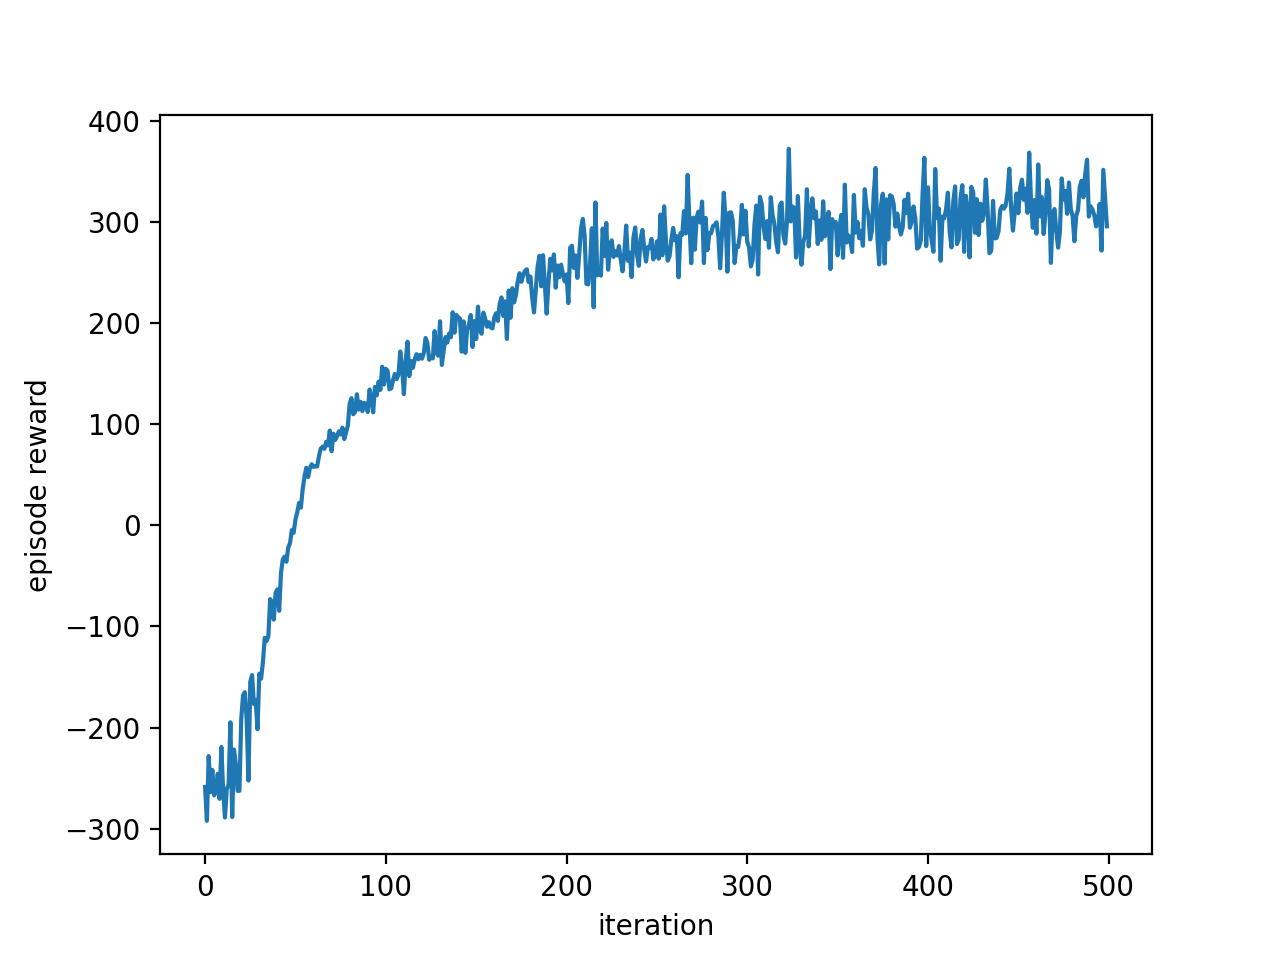

In [38]:
chart = Chart()
chart.plot(mean_reward)